In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

In [19]:
cities = pd.read_csv('cities/vanuatu.csv', header = None, names = ['city', 'x', 'y'], index_col = 0)
dist_matrix = np.zeros((cities.shape[0], cities.shape[0]))
x_coords = cities['x'].values
y_coords = cities['y'].values

# Use broadcasting to calculate the Euclidean distance for all pairs of cities
dist_matrix = np.sqrt((x_coords[:, np.newaxis] - x_coords[np.newaxis, :])**2 + 
                      (y_coords[:, np.newaxis] - y_coords[np.newaxis, :])**2)
# Set diagonal to infinity to avoid self-loops (distance from a city to itself is set to inf)
np.fill_diagonal(dist_matrix, np.inf)

In [20]:
def plot_tsp_tour(cities, tour):
    # Extract x and y coordinates of the cities
    x_coords = cities['x'].values
    y_coords = cities['y'].values

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Plot the cities as points
    ax.scatter(x_coords, y_coords, color='red', s=50, label='Cities')

    # Highlight the starting city
    start_city = tour[0]
    ax.scatter(x_coords[start_city], y_coords[start_city], color='green', s=100, label='Starting City', edgecolor='black', zorder=5)

    # Annotate each city with its index for clarity
    for i, city in enumerate(cities.index):
        ax.annotate(city, (x_coords[i], y_coords[i]), textcoords="offset points", xytext=(0, 5), ha='center')

    # Extract the coordinates of the tour in the order of visits
    tour_x = x_coords[tour]
    tour_y = y_coords[tour]

    # Plot the tour lines connecting the cities
    ax.plot(tour_x, tour_y, color='blue', label='Tour')

    # Set labels and title
    ax.set_xlabel('X coordinate')
    ax.set_ylabel('Y coordinate')
    ax.set_title('TSP Tour')

    # Display legend
    ax.legend()

    # Show the plot
    plt.show()

## First solution

Fast but approximated algorithm

Tour: [('Isangel', 0), ('Vila', 7), ('Lakatoro', 1), ('Norsup', 4), ('Luganville', 3), ('Port Olry', 5), ('Longana', 2), ('Sola', 6), ('Isangel', 0)]
Final cost: 13.42256271273651
Number of steps: 8


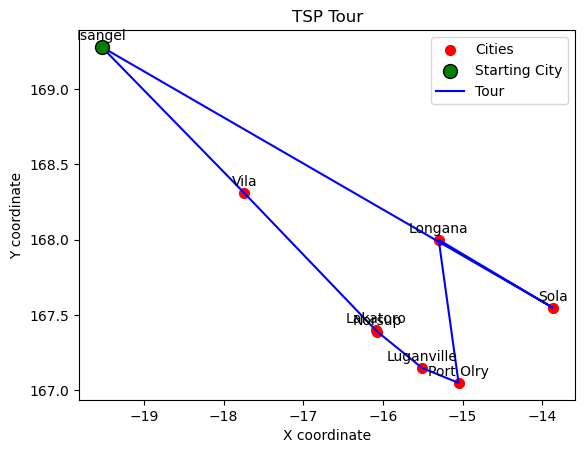

In [21]:
def greedy_tsp(dist_matrix):
    num_cities = dist_matrix.shape[0]
    visited = [False] * num_cities
    tour = []
    total_cost = 0

    # randomize the starting city
    #current_city = random.randint(0, num_cities - 1)
    
    # start from the first city
    current_city = 0
    tour.append(current_city)
    visited[current_city] = True

    for _ in range(num_cities - 1):
        # Find the nearest unvisited city
        next_city = np.argmin([dist_matrix[current_city, j] if not visited[j] else np.inf for j in range(num_cities)])
        tour.append(next_city)
        total_cost += dist_matrix[current_city, next_city]
        visited[next_city] = True
        current_city = next_city

    # Return to the starting city
    total_cost += dist_matrix[current_city, tour[0]]
    tour.append(tour[0])

    # Create a list of (city_name, city_index) tuples for the tour
    tour_list = [(cities.index[tour[i]], tour[i]) for i in range(len(tour))]

    return tour_list, total_cost, len(tour) - 1  # len(tour) - 1 is the number of steps

# Run the algorithm and get the result
tour, final_cost, steps = greedy_tsp(dist_matrix)
print(f"Tour: {tour}")
print(f"Final cost: {final_cost}")
print(f"Number of steps: {steps}")

plot_tsp_tour(cities, [city_index for _, city_index in tour])

## Second solution

Slower but more accurate algorithm

Generation 0: best length = 12.298806424680354
Generation 100: best length = 12.222715181686972
Generation 200: best length = 12.222715181686972
Generation 300: best length = 12.222715181686972
Generation 400: best length = 12.222715181686972
Generation 500: best length = 12.22271518168697
Generation 600: best length = 12.22271518168697
Generation 700: best length = 12.22271518168697
Generation 800: best length = 12.22271518168697
Generation 900: best length = 12.22271518168697

Tour: [('Norsup', 4), ('Lakatoro', 1), ('Vila', 7), ('Isangel', 0), ('Longana', 2), ('Sola', 6), ('Port Olry', 5), ('Luganville', 3), ('Norsup', 4)]
Final cost: 12.22271518168697
Number of steps (generations processed): 1000


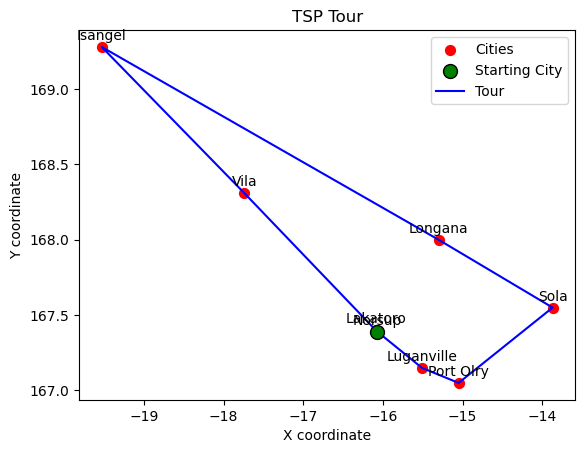

In [22]:
# Function to calculate the total length of a given route
def route_length(route):
    return sum(dist_matrix[route[i], route[i + 1]] for i in range(len(route) - 1)) + dist_matrix[route[-1], route[0]]

# Function to create an initial population of random routes
def create_population(size, n_cities):
    return [np.random.permutation(n_cities) for _ in range(size)]

# Selection function using roulette wheel selection
def selection(population):
    fitness = np.array([1 / route_length(route) for route in population])  # Calculate fitness as inverse of route length
    fitness /= fitness.sum()  # Normalize fitness values
    return population[np.random.choice(range(len(population)), p=fitness)]  # Select a route based on fitness probabilities

# Crossover function to combine two parent routes into one child route
def crossover(parent1, parent2):
    size = len(parent1)
    start, end = sorted(random.sample(range(size), 2))  # Select two random crossover points
    child = [-1] * size  # Initialize child route with -1
    child[start:end] = parent1[start:end]  # Copy segment from first parent to child
    
    current_position = end
    for city in parent2:  # Fill the rest of the child with cities from the second parent
        if city not in child:
            child[current_position] = city
            current_position = (current_position + 1) % size
    return np.array(child)

# Mutation function to introduce random changes to a route
def mutate(route, mutation_rate=0.1):
    if random.random() < mutation_rate:  # Apply mutation based on mutation rate
        idx1, idx2 = random.sample(range(len(route)), 2)  # Select two random indices
        route[idx1], route[idx2] = route[idx2], route[idx1]  # Swap the cities at these indices
    return route

# Main function to run the genetic algorithm
def genetic_algorithm(n_cities, population_size=100, generations=1000):
    population = create_population(population_size, n_cities)  # Initialize population
    best_route = None
    best_length = float('inf')  # Start with infinite best length
    total_generations = generations  # Store the total number of generations processed
   
    for generation in range(generations):
        new_population = []
        for _ in range(population_size):
            parent1 = selection(population)  # Select first parent
            parent2 = selection(population)  # Select second parent
            child = crossover(parent1, parent2)  # Create child route using crossover
            child = mutate(child)  # Apply mutation to the child route
            new_population.append(child)  # Add the new child to the population
        
        population = new_population  # Update population with new generation
        current_best = min(population, key=route_length)  # Find the best route in the population
        current_length = route_length(current_best)  # Calculate its length
        
        # Update the best route and length if current is better
        if current_length < best_length:
            best_route = current_best
            best_length = current_length
            
        # Print progress every 100 generations
        if generation % 100 == 0:
            print(f"Generation {generation}: best length = {best_length}")
    
    # Add to best route the starting city at the end to complete the cycle
    best_route = np.append(best_route, best_route[0])

    # Create a list of (city_name, city_index) tuples for the tour
    tour_list = [(cities.index[best_route[i]], best_route[i]) for i in range(len(best_route))]
   
    return best_route, best_length, tour_list, total_generations  # Return the best route, length, tour, and total generations

# Execute the genetic algorithm
best_route, best_length, tour_list, total_generations = genetic_algorithm(cities.shape[0])
print()
print(f"Tour: {tour_list}")
print(f"Final cost: {best_length}")
print(f"Number of steps (generations processed): {total_generations}")


# Visualize the best tour found
plot_tsp_tour(cities, best_route)